## Imports and Set Run Parameters

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# set parameters
label = 'deaths'
percent_test = 0.5
lag_window = [i+7 for i in range(7)]
lag_window

[7, 8, 9, 10, 11, 12, 13]

## Load and Explore Data

In [3]:
# Load Data
df_ny = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
df_meta_data = pd.read_csv('../ACS_full_data_wo_over_60.csv')

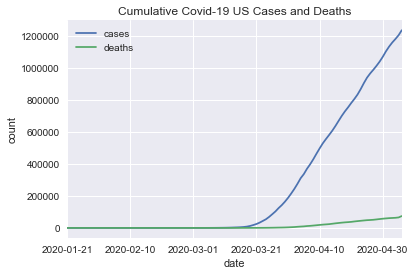

In [4]:
# plot total US cases
case_counts = df_ny[['date','cases','deaths']].groupby('date').sum()
ax = case_counts.plot(title='Cumulative Covid-19 US Cases and Deaths')
ax.set_ylabel("count")

plt.savefig('images/case_counts.png')

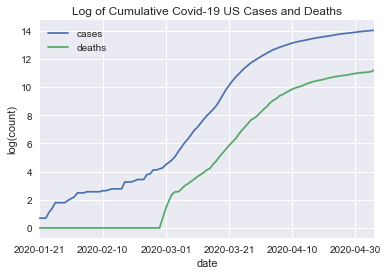

In [5]:
# plot log of US Cases
df_ny1 = df_ny.copy()
case_counts = df_ny1[['date','cases','deaths']].groupby('date').sum()
case_counts['cases'] = np.log(case_counts['cases'] + 1)
case_counts['deaths'] = np.log(case_counts['deaths'] + 1)
ax = case_counts.plot(title='Log of Cumulative Covid-19 US Cases and Deaths')
ax.set_ylabel("log(count)")
case_counts.head()
plt.savefig('images/logcase_counts.png')

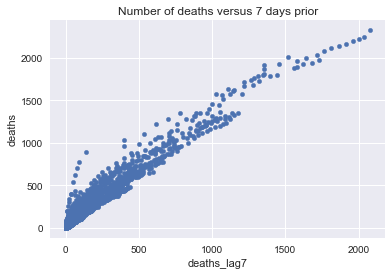

In [6]:
# plot cases versus cases from 7 days prior by fips
df_ny2 = df_ny.copy()
for i in [6]:
    df_ny2[f'cases_lag{str(i+1)}'] = df_ny2.groupby(['fips'])['cases'].shift((i+1))
    df_ny2[f'deaths_lag{str(i+1)}'] = df_ny2.groupby(['fips'])['deaths'].shift((i+1))
    

df_ny2.plot.scatter(x='deaths_lag7',y='deaths', title='Number of deaths versus 7 days prior')
plt.savefig('images/deaths_7d.png')

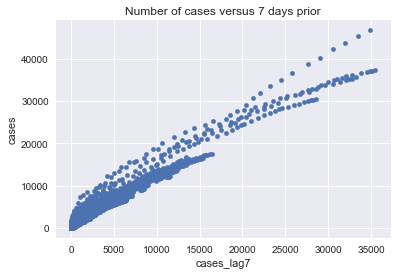

In [7]:
df_ny2.plot.scatter(x='cases_lag7',y='cases', title='Number of cases versus 7 days prior')
plt.savefig('images/cases_7d.png')

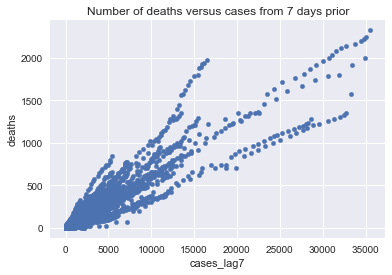

In [8]:
df_ny2.plot.scatter(x='cases_lag7',y='deaths', title='Number of deaths versus cases from 7 days prior')
plt.savefig('images/cases_deaths_7d.png')

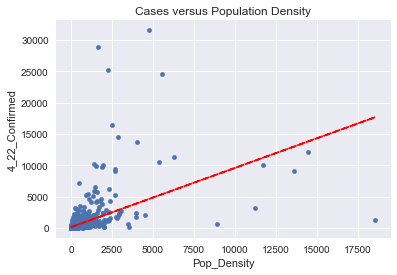

In [9]:
import matplotlib.pyplot as plt
df_meta_data.plot.scatter('Pop_Density', '4_22_Confirmed')
z = np.poly1d(np.polyfit(df_meta_data['Pop_Density'], df_meta_data['4_22_Confirmed'], 1))
ax = plt.plot(df_meta_data['Pop_Density'],z(df_meta_data['Pop_Density']),"r--")
plt.title('Cases versus Population Density')
plt.savefig('images/cases_pop.png')

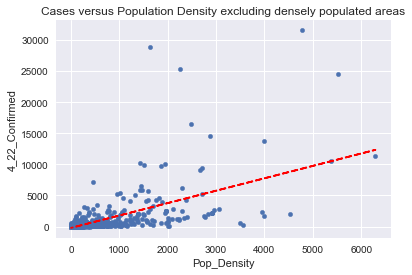

In [10]:
df_meta_data1 = df_meta_data[df_meta_data['Pop_Density'] < 7500]
df_meta_data1.plot.scatter('Pop_Density', '4_22_Confirmed')
z = np.poly1d(np.polyfit(df_meta_data1['Pop_Density'], df_meta_data1['4_22_Confirmed'], 1))
plt.plot(df_meta_data1['Pop_Density'],z(df_meta_data1['Pop_Density']),"r--")
plt.title('Cases versus Population Density excluding densely populated areas')
plt.savefig('images/cases_pop_noout.png')

In [11]:
from scipy.stats import spearmanr
print(spearmanr(df_meta_data[['Pop_Density']].values, df_meta_data[['4_22_Confirmed']].values))
print(df_meta_data[['Pop_Density', '4_22_Confirmed']].corr())

SpearmanrResult(correlation=0.7272491091466564, pvalue=3.515313646282204e-243)
                Pop_Density  4_22_Confirmed
Pop_Density        1.000000        0.501955
4_22_Confirmed     0.501955        1.000000


## Clean/Tranform and Merge Data

In [12]:
# data clease cases - filter out entries with fewer than 10 deaths
df_ny = df_ny[['date','state','county', 'fips','cases','deaths']]
df_ny = df_ny[df_ny['deaths']>=10]
df_ny['state'] = df_ny['state'].str.lower()

In [13]:
# data clease meta - transform state for join
df_meta_data = df_meta_data.rename(str.lower, axis = 'columns')
df_meta_data['state'] = df_meta_data['state'].str.lower()

In [14]:
# merge data on cases with meta data
df_merged = pd.merge(df_ny, df_meta_data, how = 'inner', left_on=["county", "state"], right_on=["county", "state"])

In [15]:
# create lagged data
for i in lag_window:
    df_merged[f'cases_lag{str(i+1)}'] = df_merged.groupby(['fips'])['cases'].shift((i+1))
    df_merged[f'deaths_lag{str(i+1)}'] = df_merged.groupby(['fips'])['deaths'].shift((i+1))

In [16]:
# create additional features
df_merged['pctMale'] = df_merged['e_total_pop_sex_male']/df_merged['et_total_population']
df_merged['pctSS'] = df_merged['e_total_households_with_income_with_social_security']/df_merged['et_total_population']
df_merged['pctRetInc'] = df_merged['e_total_households_with_income_with_retirement_income']/df_merged['et_total_population']
df_merged['pctWhite'] = df_merged['e_total_pop_race_white']/df_merged['et_total_population']
df_merged['pctPoverty'] = df_merged['e_total_pop_poverty_status_below_100_percent']/df_merged['et_total_population']

## Split Train and Test and Standardize Features

In [17]:
# split into train and test based on county (fips)
num_train = int(len(df_merged['fips'].unique()))
unique_counties_np = df_merged['fips'].unique()
unique_counties = pd.DataFrame(data = unique_counties_np)

train_counties = unique_counties.sample(int(num_train * (1-percent_test)))
test_counties = unique_counties.loc[~unique_counties.index.isin(train_counties.index)]

In [18]:
# extract train and test data
train_counties = train_counties[0].values.tolist()
test_counties = test_counties[0].values.tolist()
df_train = df_merged[df_merged['fips'].isin(train_counties)]
df_test =  df_merged[df_merged['fips'].isin(test_counties)]

df_train= df_train.dropna()
df_test= df_test.dropna()

In [19]:
# standardize features - train and test separately
s0 = df_train.iloc[:,4:]
df_train.iloc[:,4:] = (s0 - s0.mean()) / (s0.max() - s0.min())

s0 = df_test.iloc[:,4:]
df_test.iloc[:,4:] = (s0 - s0.mean()) / (s0.max() - s0.min())

# Benchmark - Linear Regression

In [20]:
# extract features and targets
feature_list = ['pop_density','et_total_population', 'em_total_pop_median_age', 'em_transportation_mean_travel_time', 'em_total_housing_units_avg_household_size_rented', 'pctMale', 'pctSS', 'pctRetInc', 'pctWhite', 'pctPoverty']
feature_list.extend([f'cases_lag{i+1}' for i in lag_window])
feature_list.extend([f'deaths_lag{i+1}' for i in lag_window])

In [21]:
import d2l
from mxnet import autograd, gluon, np, npx, init
npx.set_np()
import pandas as pd
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn

In [22]:
train_labels = np.array(df_train[[label]].values, dtype=np.float32).reshape(-1, 1)
train_features = np.array(df_train[feature_list].values, dtype=np.float32)
test_labels = np.array(df_test[[label]].values, dtype=np.float32).reshape(-1, 1)
test_features = np.array(df_test[feature_list].values, dtype=np.float32)
train_features=train_features.reshape((train_features.shape[0], train_features.shape[1], 1))
test_features=test_features.reshape((test_features.shape[0], test_features.shape[1], 1))

In [23]:
# Copied from d2l textbook
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 8 # train set size is divisible by 12
train_iter = load_array((train_features, train_labels), batch_size)
test_iter = load_array((test_features, test_labels), batch_size, is_train=False)

In [24]:
# initialize model
net = nn.Sequential()
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))
loss = gloss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.001})

In [25]:
# run model and save loss results
results_list = []
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    for X, y in train_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(train_features), train_labels)
    l_test = loss(net(test_features), test_labels)
    
    results_dict = {'epoch': epoch + 1, 
                'train_loss': l.mean(), 
                'test_loss': l_test.mean()}
    results_list.append(results_dict)
    print('epoch %d, loss_train: %f, loss_test: %f' % (epoch, l.mean().asnumpy(), l_test.mean().asnumpy()))

epoch 1, loss_train: 0.007254, loss_test: 0.010434
epoch 2, loss_train: 0.006730, loss_test: 0.009799
epoch 3, loss_train: 0.006248, loss_test: 0.009210
epoch 4, loss_train: 0.005806, loss_test: 0.008665
epoch 5, loss_train: 0.005399, loss_test: 0.008160
epoch 6, loss_train: 0.005024, loss_test: 0.007692
epoch 7, loss_train: 0.004680, loss_test: 0.007258
epoch 8, loss_train: 0.004364, loss_test: 0.006855
epoch 9, loss_train: 0.004073, loss_test: 0.006481
epoch 10, loss_train: 0.003805, loss_test: 0.006134
epoch 11, loss_train: 0.003559, loss_test: 0.005812
epoch 12, loss_train: 0.003333, loss_test: 0.005513
epoch 13, loss_train: 0.003124, loss_test: 0.005234
epoch 14, loss_train: 0.002932, loss_test: 0.004976
epoch 15, loss_train: 0.002756, loss_test: 0.004735
epoch 16, loss_train: 0.002593, loss_test: 0.004511
epoch 17, loss_train: 0.002444, loss_test: 0.004303
epoch 18, loss_train: 0.002306, loss_test: 0.004109
epoch 19, loss_train: 0.002179, loss_test: 0.003928
epoch 20, loss_train:

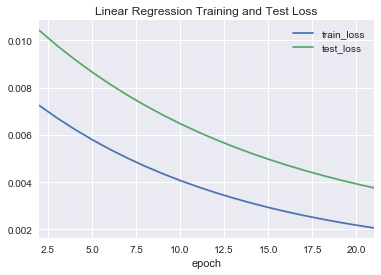

In [26]:
# extract results
df_out = pd.DataFrame(results_list)
df_out = df_out.astype({'train_loss': 'float32', 'test_loss': 'float32'})

# plot results
df_out.plot(x='epoch', y=['train_loss', 'test_loss'], title='Linear Regression Training and Test Loss')

# Model 2: 1D ConvNet Implementation

In [27]:
import numpy as nd
pd.options.display.max_columns = None
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from mxnet.gluon import loss as gloss
npx.set_np()

In [28]:
# extract features and targets
feature_list = ['pop_density','et_total_population', 'em_total_pop_median_age', 'em_transportation_mean_travel_time', 'em_total_housing_units_avg_household_size_rented', 'pctMale', 'pctSS', 'pctRetInc', 'pctWhite', 'pctPoverty']
feature_list.extend([f'cases_lag{i+1}' for i in lag_window])
feature_list.extend([f'deaths_lag{i+1}' for i in lag_window])

In [29]:
train_labels = np.array(df_train[[label]].values, dtype=np.float32).reshape(-1, 1)
train_features = np.array(df_train[feature_list].values, dtype=np.float32)
test_labels = np.array(df_test[[label]].values, dtype=np.float32).reshape(-1, 1)
test_features = np.array(df_test[feature_list].values, dtype=np.float32)
train_features=train_features.reshape((train_features.shape[0], train_features.shape[1], 1))
test_features=test_features.reshape((test_features.shape[0], test_features.shape[1], 1))

In [30]:
net = nn.Sequential()
net.add(nn.Conv1D(channels=10, kernel_size=3, padding=2, activation='relu'),
        nn.AvgPool1D(pool_size=2, strides=1),
        nn.Dense(64, activation='relu'),
        nn.Dense(32, activation='relu'),
        nn.Dense(1))

In [31]:
X = train_features
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1759, 10, 3)
pool0 output shape:	 (1759, 10, 2)
dense1 output shape:	 (1759, 64)
dense2 output shape:	 (1759, 32)
dense3 output shape:	 (1759, 1)


In [32]:
batch_size = 10
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

train_iter = load_array((train_features, train_labels), batch_size)
test_iter = load_array((test_features, test_labels), batch_size)

In [33]:
from sklearn import metrics
num_epochs, lr = 20, 0.5
results_list = []
loss = gloss.L2Loss()
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': lr})
for epoch in range(1, num_epochs + 1):
    for i, (X, y) in enumerate(train_iter):
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(X.shape[0])
    train_loss = loss(net(train_features), train_labels)
    test_loss = loss(net(test_features), test_labels)
    train_rmse=np.sqrt(metrics.mean_squared_error(net(train_features), train_labels))
    test_rmse=np.sqrt(metrics.mean_squared_error(net(test_features), test_labels))
    results_dict = {'epoch': epoch, 
                'train_loss': train_loss.mean().asnumpy(), 
                'test_loss': test_loss.mean().asnumpy(),
                'train_rmse': train_rmse,
                'test_rmse': test_rmse}
    results_list.append(results_dict)
    
    print("epoch: {} | trn_loss: {:.8f}, test_loss: {:.8f}".format(epoch,float(train_loss.mean()), float(test_loss.mean())))
    
    
    

epoch: 1 | trn_loss: 0.00758676, test_loss: 0.01054662
epoch: 2 | trn_loss: 0.00769834, test_loss: 0.01065413
epoch: 3 | trn_loss: 0.00747770, test_loss: 0.01042294
epoch: 4 | trn_loss: 0.00975163, test_loss: 0.01265081
epoch: 5 | trn_loss: 0.00456333, test_loss: 0.00691860
epoch: 6 | trn_loss: 0.00067500, test_loss: 0.00114571
epoch: 7 | trn_loss: 0.00058816, test_loss: 0.00101597
epoch: 8 | trn_loss: 0.00088261, test_loss: 0.00130283
epoch: 9 | trn_loss: 0.00054464, test_loss: 0.00099424
epoch: 10 | trn_loss: 0.00062871, test_loss: 0.00113297
epoch: 11 | trn_loss: 0.00051809, test_loss: 0.00094377
epoch: 12 | trn_loss: 0.00052869, test_loss: 0.00097958
epoch: 13 | trn_loss: 0.00055877, test_loss: 0.00104118
epoch: 14 | trn_loss: 0.00049864, test_loss: 0.00094588
epoch: 15 | trn_loss: 0.00046706, test_loss: 0.00089640
epoch: 16 | trn_loss: 0.00045540, test_loss: 0.00094632
epoch: 17 | trn_loss: 0.00044616, test_loss: 0.00095326
epoch: 18 | trn_loss: 0.00043798, test_loss: 0.00095428
e

In [34]:
# extract results
df_out = pd.DataFrame(results_list)
df_out = df_out.astype({'train_loss': 'float32', 'test_loss': 'float32','train_rmse':'float32','test_rmse':'float32'})

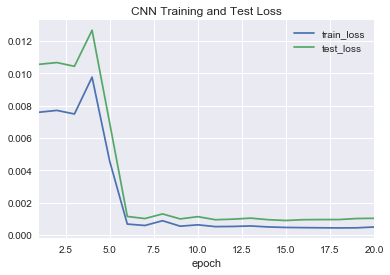

In [35]:
# plot results
df_out.plot(x='epoch', y=['train_loss', 'test_loss'], title='CNN Training and Test Loss')

# Model 3: MLP Implementation

In [36]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='tanh'), # relu | tanh
        nn.Dense(256),
        nn.Dense(128, activation='tanh'),
        nn.Dense(1))

net.initialize()

In [37]:
batch_size = 10
train_iter = load_array((train_features, train_labels), batch_size)
test_iter = load_array((test_features, test_labels), batch_size)

In [38]:
num_epochs, lr = 20, 0.1
results_list = []
loss = gloss.L2Loss()
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': lr})
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_iter):
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(X.shape[0])
    train_loss = loss(net(train_features), train_labels)
    test_loss = loss(net(test_features), test_labels)
    train_rmse=np.sqrt(metrics.mean_squared_error(net(train_features), train_labels))
    test_rmse=np.sqrt(metrics.mean_squared_error(net(test_features), test_labels))
    
    results_dict = {'epoch': epoch, 
                'train_loss': train_loss.mean().asnumpy(), 
                'test_loss': test_loss.mean().asnumpy(),
                'train_rmse': train_rmse,
                'test_rmse': test_rmse}
    results_list.append(results_dict)
    
    print("epoch: {} | trn_loss: {:.8f}, test_loss: {:.8f}".format(epoch,float(train_loss.mean()), float(test_loss.mean())))
    

epoch: 0 | trn_loss: 0.00241887, test_loss: 0.00412743
epoch: 1 | trn_loss: 0.00078956, test_loss: 0.00154562
epoch: 2 | trn_loss: 0.00068481, test_loss: 0.00114315
epoch: 3 | trn_loss: 0.00063752, test_loss: 0.00112585
epoch: 4 | trn_loss: 0.00062379, test_loss: 0.00113674
epoch: 5 | trn_loss: 0.00060615, test_loss: 0.00107946
epoch: 6 | trn_loss: 0.00059495, test_loss: 0.00106043
epoch: 7 | trn_loss: 0.00058386, test_loss: 0.00107614
epoch: 8 | trn_loss: 0.00057418, test_loss: 0.00104506
epoch: 9 | trn_loss: 0.00056647, test_loss: 0.00105474
epoch: 10 | trn_loss: 0.00056470, test_loss: 0.00102757
epoch: 11 | trn_loss: 0.00055295, test_loss: 0.00108465
epoch: 12 | trn_loss: 0.00054372, test_loss: 0.00107758
epoch: 13 | trn_loss: 0.00053625, test_loss: 0.00104006
epoch: 14 | trn_loss: 0.00053400, test_loss: 0.00108482
epoch: 15 | trn_loss: 0.00053049, test_loss: 0.00109314
epoch: 16 | trn_loss: 0.00051704, test_loss: 0.00103895
epoch: 17 | trn_loss: 0.00051430, test_loss: 0.00100748
ep

In [39]:
# extract results
df_out = pd.DataFrame(results_list)
df_out = df_out.astype({'train_loss': 'float32', 'test_loss': 'float32','train_rmse':'float32','test_rmse':'float32'})

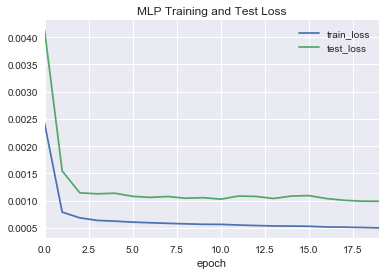

In [40]:
# plot results
df_out.plot(x='epoch', y=['train_loss', 'test_loss'], title='MLP Training and Test Loss')